In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# The following is used for the independent t-test
from scipy.stats import ttest_ind  

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# First, show the columns in the "Measurement" and "Station" tables
inspector = inspect (engine)

print ('*'*30)
print ("Measurement Table")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    
print ('*'*30)
print ("Station Table")
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])
print ('*'*30)


******************************
Measurement Table
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
******************************
Station Table
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
******************************


In [11]:
# Find the "first date" and "last dates" for all the stations.
session.query(Measurement.station, func.min(Measurement.date), func.max(Measurement.date))\
               .group_by(Measurement.station).all()

[('USC00511918', '2010-01-01', '2015-10-30'),
 ('USC00513117', '2010-01-01', '2017-07-31'),
 ('USC00514830', '2010-03-01', '2017-08-23'),
 ('USC00516128', '2010-01-01', '2017-08-23'),
 ('USC00517948', '2010-05-03', '2017-07-31'),
 ('USC00518838', '2010-01-01', '2015-11-20'),
 ('USC00519281', '2010-01-01', '2017-08-18'),
 ('USC00519397', '2010-01-01', '2017-08-23'),
 ('USC00519523', '2010-01-01', '2017-08-23')]

In [12]:
# Find the latest of the "last dates", use this as the end date for the 12 months of precipitation
date_string = session.query(func.max(Measurement.date)).group_by(Measurement.station).\
        order_by(func.max(Measurement.date).desc()).limit(1).all()[0][0]
LTM_end = dt.datetime.strptime(date_string, '%Y-%m-%d').date()

# Set the start date to be 365 days earlier
LTM_start = LTM_end - dt.timedelta(days=364)

print (f'Start date is {LTM_start}, and end date is {LTM_end}')

Start date is 2016-08-24, and end date is 2017-08-23


## Precipitation Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# This was done in the cell above.

# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date>=LTM_start).filter(Measurement.date<=LTM_end)

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.read_sql(query_results.statement, engine)
rain_df.dropna(inplace=True)

# Sort the dataframe by date
rain_df.set_index("date",inplace=True)
rain_df.sort_index(0,inplace=True)
rain_df.rename(columns={"prcp": "precipitation"}, inplace=True)
rain_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


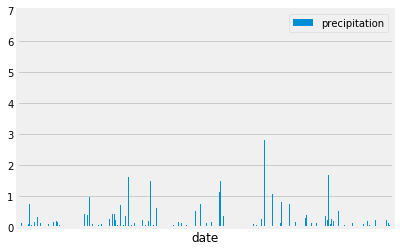

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

# Per the sample provided, I'm hiding the x-axis labels
rain_df.plot(kind='bar',y='precipitation')
plt.xticks([])
plt.show()

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

## Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
n_stations = len(session.query(Measurement.station).group_by(Measurement.station).all())
n_stations

# For the station numbers, see the query above that lists the start and end dates of data for each station

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# First, find the most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.prcp).desc()).limit(1).all()[0][0]
most_active_station

'USC00519281'

In [19]:
# Now, find the lowest temp, highest temp and average temp
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station==most_active_station).all()
print (f'The lowest temp was {temps[0][0]:.1f}, the highest temp was {temps[0][1]:.1f}, and the average was {temps[0][2]:.1f}!!!')


The lowest temp was 54.0, the highest temp was 85.0, and the average was 71.7!!!


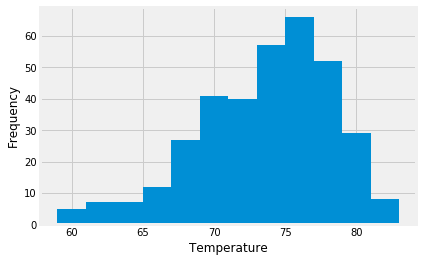

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.tobs).filter(Measurement.station==most_active_station)\
    .filter(Measurement.date>=LTM_start).filter(Measurement.date<=LTM_end).all()

# Flatten the results of the query
temps2 = [val for sublist in temps for val in sublist]

# Plot the histogram
temp_bins = np.arange(59,85,2)
plt.hist(temps2, bins=temp_bins)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()


![precipitation](Images/station-histogram.png)

## Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# The trip dates I've selected are January 1, 2017 to January 14, 2017
trip_start = "2017-01-01"
trip_end = "2017-01-14"

trip_temps = calc_temps(trip_start, trip_end)
print (trip_temps)

[(60.0, 68.47619047619048, 81.0)]


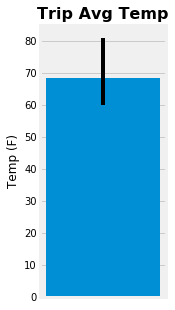

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Set the size of the graph
plt.figure(figsize=(2,5))

# Give it a title, and labels for the Y axis
plt.title("Trip Avg Temp", fontsize=16, fontweight="bold")
plt.ylabel("Temp (F)")

# Work with the data
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

yerr_low = avg_temp - min_temp
yerr_high = max_temp - avg_temp

# Add grid lines
plt.grid(axis='x')

# Disable x-axis tick marks
plt.xticks([])

# Draw the one bar, with error bar
plt.bar(1, avg_temp, yerr=[[yerr_low],[yerr_high]], width=.4)

# Save the Figure
plt.savefig ('graph1.png')

# Show the Figure
plt.show()


## Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Save the results in a dataframe and print that, so that it's easier to read

query_results = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, \
                Station.latitude, Station.longitude, Station.elevation)\
        .group_by(Measurement.station)\
        .filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end)\
        .filter(Measurement.station == Station.station)\
        .order_by(func.sum(Measurement.prcp).desc())

trip_rain_df = pd.read_sql(query_results.statement, engine)

trip_rain_df.rename(columns={"sum_1": "total precip"}, inplace=True)
trip_rain_df.head(20)

,station,total precip,name,latitude,longitude,elevation
0,USC00514830,0.63,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
1,USC00516128,0.63,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00519523,0.61,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00513117,0.35,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519281,0.21,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,USC00519397,0.00,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# These have been defined earlier as "trip_start" and "trip_end"

# Use the start and end date to create a range of dates
vacation_dates = pd.date_range(trip_start, trip_end).tolist()

# Strip off the year and save a list of %m-%d strings
vdates_mm_dd = [vdate.strftime("%m-%d") for vdate in vacation_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
vdates_normals = [daily_normals(vdatemd) for vdatemd in vdates_mm_dd]

# The prior statement returned a list with 14 lists, and inside each of the 14 lists was a set of 3 items.
# Flatten the list so that we get a list of 14 sets, each set containting 3 items.
vdates_normals2 = [val for sublist in vdates_normals for val in sublist]
vdates_normals2

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0)]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Create a dataframe of the temperatures
vdates_temps_df = pd.DataFrame(vdates_normals2, columns=["temp_min", "temp_avg", "temp_max"])

# Create a dataframe of the dates
vdate_df = pd.DataFrame(vdates_mm_dd, columns=["trip_dates"])

# Concat the dataframes 
result_df = pd.concat([vdate_df, vdates_temps_df], axis=1, sort=False)

# Set the "trip_dates" to be the index
result_df.set_index("trip_dates",inplace=True)

# Display the results
result_df.head(30)



,temp_min,temp_avg,temp_max
trip_dates,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0


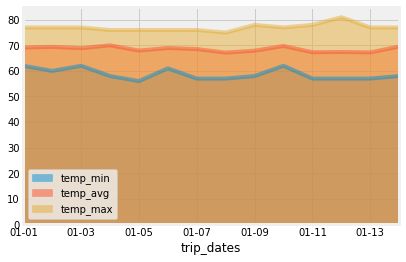

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
result_df.plot.area(stacked=False)
plt.show()

## Temperature Analysis I

In [29]:
# Identify the average temperature in June at all stations across all available years in the dataset.
# I interpret this to mean that I should calculate the average temperature for each day in June
query_results = session.query(func.strftime("%d", Measurement.date), func.avg(Measurement.tobs))\
        .group_by(func.strftime("%d", Measurement.date)) \
        .filter(func.strftime("%m", Measurement.date) == '06')

june_df = pd.read_sql(query_results.statement, engine)
june_df.rename(columns={"strftime_1": "june day", "avg_1": "avg_temp"}, inplace=True)
june_df.head(40)

,june day,avg_temp
0,01,74.614035
1,02,74.400000
2,03,74.034483
3,04,73.818182
4,05,74.854545
5,06,75.175439
6,07,75.071429
7,08,75.586207
8,09,75.152542
9,10,75.142857


In [30]:
# Do the same for December
query_results = session.query(func.strftime("%d", Measurement.date), func.avg(Measurement.tobs))\
        .group_by(func.strftime("%d", Measurement.date)) \
        .filter(func.strftime("%m", Measurement.date) == '12')

dec_df = pd.read_sql(query_results.statement, engine)
dec_df.rename(columns={"strftime_1": "dec day", "avg_1": "avg_temp"}, inplace=True)
dec_df.head(40)

,dec day,avg_temp
0,01,71.916667
1,02,71.326923
2,03,72.886792
3,04,72.176471
4,05,70.921569
5,06,69.392157
6,07,69.200000
7,08,70.274510
8,09,71.901961
9,10,71.245283


In [31]:
# Use a t-test to determine whether the difference in the means, if any, is statistically signficant.  
# Will you use a paired t-test, or an unpaired t-test? Why?

# According to "https://www.openanesthesia.org/paired-vs-unpaired-t-test/", 
# here is the difference between a paired t-test and an unpaired t-test.
# Paired t-test compares study subjects at 2 different times (paired observations of the same subject). 
# Unpaired t-test (aka Student’s test) compares two different subjects. 
# The paired t-test reduces intersubject variability (because it makes comparisons between the same subject), 
# and thus is theoretically more powerful than the unpaired t-test.

# Since June and December are different months, I will be using the unpaired t-test.

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(june_df['avg_temp'].tolist(), dec_df['avg_temp'].tolist(), equal_var=False)
print("ttest_ind: t = %g  p = %g" % (t, p))

ttest_ind: t = 17.6197  p = 5.09331e-22


#### With a t-score of 17.6 and a p-value of 5.09e-22, in other words, 22 zeros after the decimal and before the first non-zero digit, we can easily say that the mean temperature in June is different from the mean temperature in December.